In [1]:
import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

print(tf.__version__)

print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

/Users/mukish/Documents/ibots/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.16.1
The following GPU devices are available: 


In [2]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [4]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [5]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

def load_local_image(image_path):
    with open(image_path, 'rb') as f:
        image_data = f.read()
    return Image.open(BytesIO(image_data))

def load_and_resize_image(image_path, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    with open(image_path, 'rb') as f:
        image_data = f.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness,
              fill=color)

    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

## Detect objects from Image

Image downloaded to /var/folders/th/0w0jsytn52z4rg5h31tv88b00000gn/T/tmptpi6p20_.jpg.


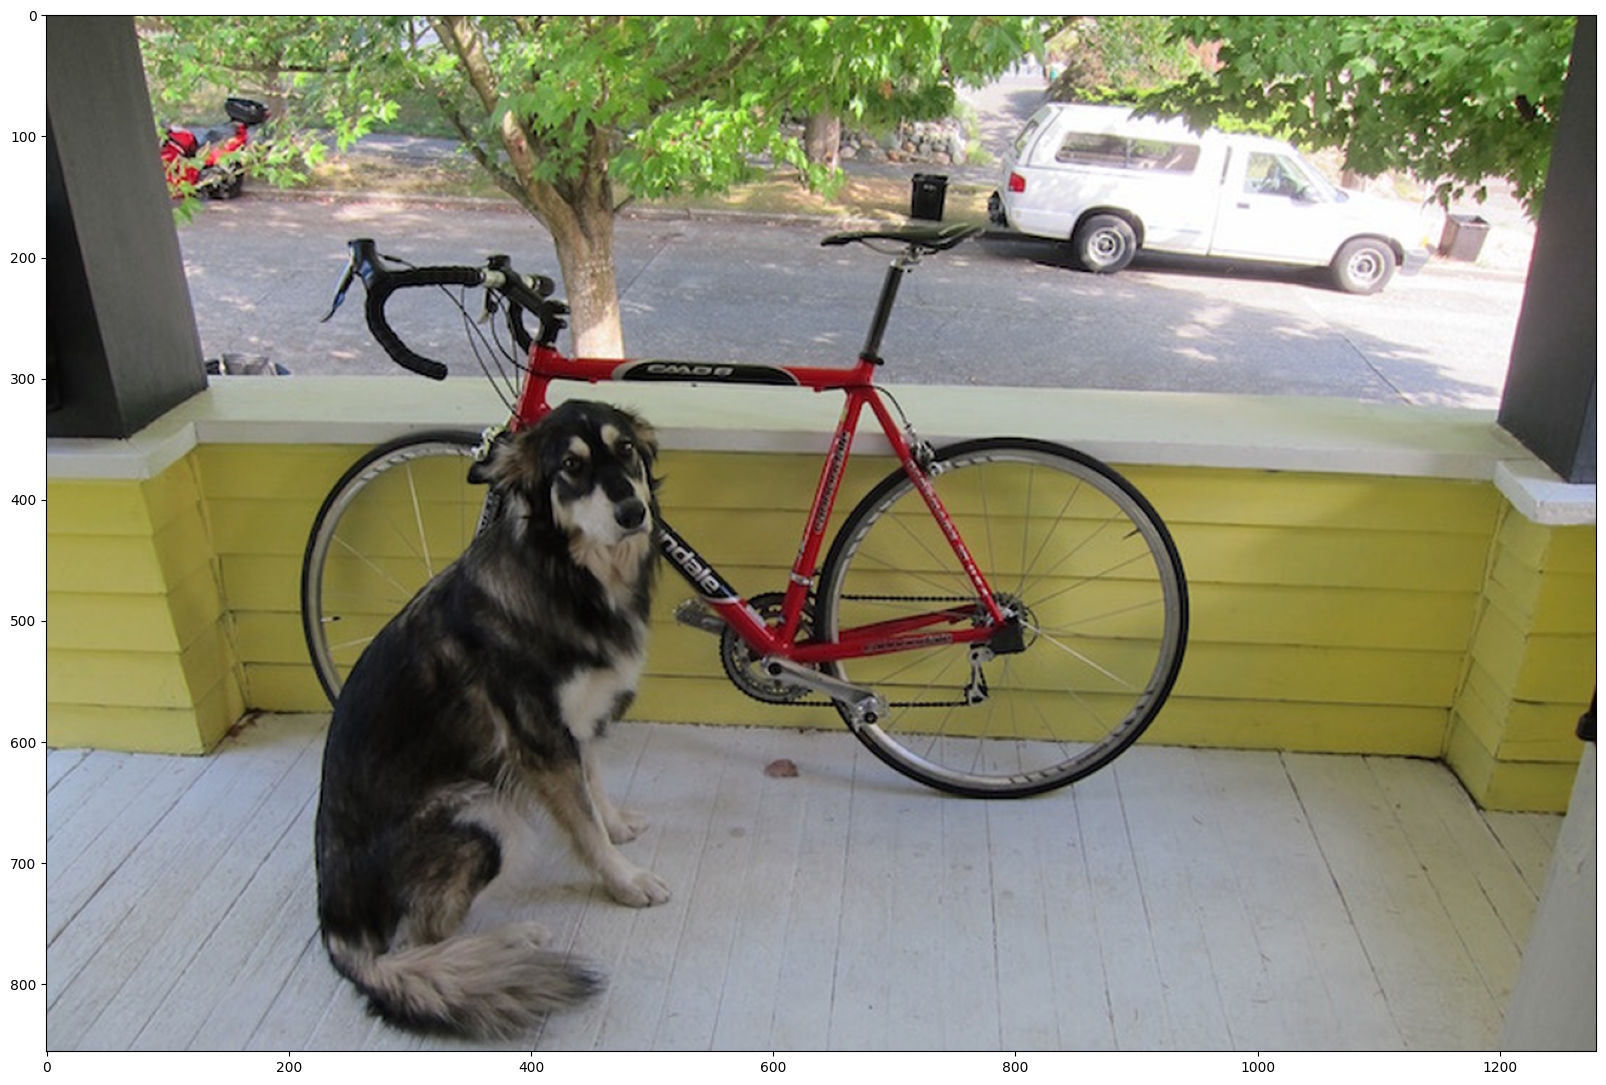

In [6]:
image_path = "dog_bike_car.jpg"
image = load_and_resize_image(image_path, 1280, 856, True)

Found 100 objects.
Inference time:  3.806452989578247
Font not found, using default font.


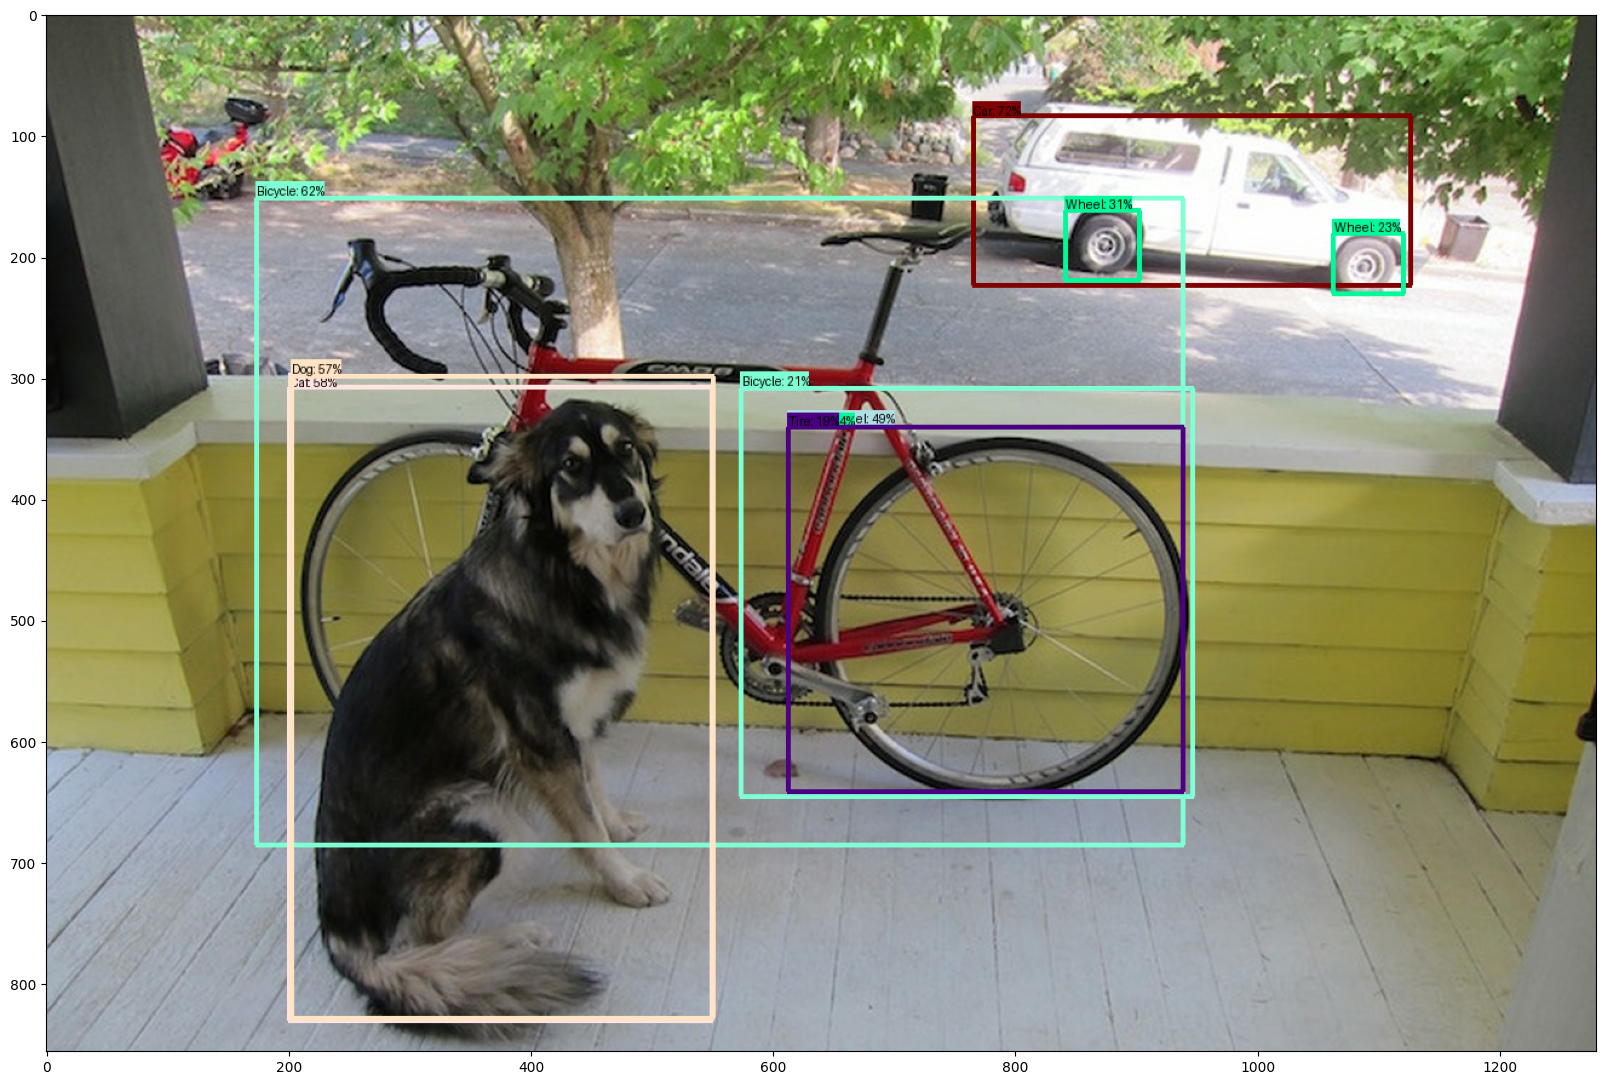

In [7]:
run_detector(detector, image)

## Detect objects from webcam

In [8]:
import cv2

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

def run_detector(detector, frame):
    converted_img = tf.image.convert_image_dtype(frame, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key: value.numpy() for key, value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    image_with_boxes = draw_boxes(
        frame.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    cv2.imshow("Object Detection", cv2.cvtColor(np.array(image_with_boxes), cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)

def webcam_object_detection():
    cap = cv2.VideoCapture(0)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Unable to capture frame from webcam.")
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        run_detector(detector, tf.convert_to_tensor(frame_rgb))

    cap.release()
    cv2.destroyAllWindows()

webcam_object_detection()

Found 100 objects.
Inference time:  0.11449003219604492
Font not found, using default font.


2024-03-17 16:29:44.100 Python[395:905471] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Found 100 objects.
Inference time:  0.05748891830444336
Font not found, using default font.
Found 100 objects.
Inference time:  0.06255269050598145
Font not found, using default font.
Found 100 objects.
Inference time:  0.07192420959472656
Font not found, using default font.
Found 100 objects.
Inference time:  0.05508303642272949
Font not found, using default font.
Found 100 objects.
Inference time:  0.05482912063598633
Font not found, using default font.
Found 100 objects.
Inference time:  0.05846595764160156
Font not found, using default font.
Found 100 objects.
Inference time:  0.06437492370605469
Font not found, using default font.
Found 100 objects.
Inference time:  0.04912304878234863
Font not found, using default font.
Found 100 objects.
Inference time:  0.04767012596130371
Font not found, using default font.
Found 100 objects.
Inference time:  0.04622983932495117
Font not found, using default font.
Found 100 objects.
Inference time:  0.04558420181274414
Font not found, using de

KeyboardInterrupt: 